### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_11/alabama/2022_11_23_09_15_43/count_data/

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
population.csv                   ylds.hdf
population.hdf                   ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_11/alabama/2022_11_23_09_15_43/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,2
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,1
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,1
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,1


In [5]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [6]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

102289760.06570841

In [8]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

102289760.06570841

### Total DALYs by Year

In [9]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,2042.799965,52.702880,2095.502845
1,female,25_to_29,29,2024,2845.209923,53.619680,2898.829603
2,female,25_to_29,29,2025,2771.491382,53.619256,2825.110637
3,female,25_to_29,29,2026,3081.985125,54.611938,3136.597064
4,female,25_to_29,29,2027,2085.423426,56.431185,2141.854612


In [10]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,6023.355861,727.617723,12720.250693
1,2024,6140.608072,776.478935,12911.704075
2,2025,6137.138560,836.329969,12913.783135
3,2026,6188.098336,861.969709,13279.411366
4,2027,6244.243555,916.974415,13194.564597


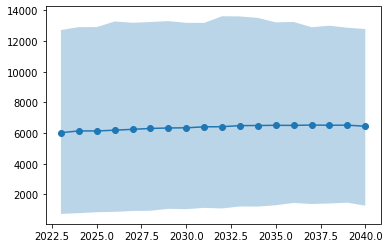

In [11]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [12]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,14.62,0.0,77.625
1,25_to_29,female,2024,14.70,0.0,76.650
2,25_to_29,female,2025,13.84,0.0,51.950
3,25_to_29,female,2026,13.50,0.0,44.525
4,25_to_29,female,2027,12.46,0.0,35.775


In [13]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model9vv_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [14]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27441.379877
1,25_to_29,female,2023,232,27571.394935
2,25_to_29,female,2023,357,27621.530459
3,25_to_29,female,2023,394,27463.151266
4,25_to_29,female,2023,602,27323.937029


In [15]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.002695,0.000968,0.008919
1,25_to_29,female,2024,0.002740,0.000912,0.008395
2,25_to_29,female,2025,0.002606,0.001149,0.008665
3,25_to_29,female,2026,0.002556,0.000947,0.008659
4,25_to_29,female,2027,0.002368,0.000980,0.007873


In [16]:
%%capture 
with PdfPages('model9_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [17]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model9_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [18]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,4.4,0.0,27.80
1,5,25_to_29,female,2024,acute_ischemic_stroke,4.2,0.0,23.05
2,10,25_to_29,female,2025,acute_ischemic_stroke,4.8,0.0,31.25
3,15,25_to_29,female,2026,acute_ischemic_stroke,3.7,0.0,25.70
4,20,25_to_29,female,2027,acute_ischemic_stroke,3.6,0.0,24.70


In [19]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,2
1,5,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,10,25_to_29,female,2023,357,acute_ischemic_stroke,1
3,15,25_to_29,female,2023,394,acute_ischemic_stroke,1
4,20,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [20]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000163,0.0,0.001031
1,25_to_29,female,2024,0.000157,0.0,0.000863
2,25_to_29,female,2025,0.000181,0.0,0.001182
3,25_to_29,female,2026,0.000141,0.0,0.000978
4,25_to_29,female,2027,0.000138,0.0,0.000946


In [21]:
%%capture 
with PdfPages('model9_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [22]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.009825,0.003212,0.013381
537,95_plus,male,2038,0.008988,0.002334,0.017721
538,95_plus,male,2039,0.008951,0.005220,0.013979
539,95_plus,male,2040,0.008055,0.004209,0.010485


In [23]:
%%capture
with PdfPages('model9_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [24]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [25]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001338,0.000008,0.006194
1,25_to_29,female,2024,0.001265,0.000045,0.005805
2,25_to_29,female,2025,0.001180,0.000092,0.005595
3,25_to_29,female,2026,0.001142,0.000092,0.005901
4,25_to_29,female,2027,0.000929,0.000084,0.004864


In [26]:
%%capture
with PdfPages('model9_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [27]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000243,0.000073,0.000628
1,25_to_29,female,2024,0.000280,0.000074,0.000885
2,25_to_29,female,2025,0.000324,0.000054,0.000941
3,25_to_29,female,2026,0.000315,0.000083,0.000782
4,25_to_29,female,2027,0.000313,0.000008,0.001001


In [28]:
%%capture
with PdfPages('model9_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [29]:
%%capture
with PdfPages('model9_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Angina

In [30]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate_summ = (angina_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

angina_rate_summ.head()

year,age,sex


In [31]:
%%capture
with PdfPages('model9_angina_csmr.pdf') as pdf:
    for sex in angina_rate_summ.sex.unique():
        for year in angina_rate_summ.year.unique():
            plt.figure() 
            subdata = angina_rate_summ.loc[(angina_rate_summ.sex==sex) & (angina_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [32]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.044497,0.023941,0.076487
1,25_to_29,female,2024,0.045292,0.021945,0.066649
2,25_to_29,female,2025,0.053983,0.026585,0.132159
3,25_to_29,female,2026,0.054294,0.030004,0.092288
4,25_to_29,female,2027,0.041146,0.003687,0.071985


In [33]:
%%capture
with PdfPages('model9_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [34]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000448,6.269138e-07,0.002510
1,25_to_29,female,2024,0.000413,3.454516e-06,0.002312
2,25_to_29,female,2025,0.000419,7.002905e-06,0.002460
3,25_to_29,female,2026,0.000372,3.534139e-06,0.002180
4,25_to_29,female,2027,0.000373,6.442395e-07,0.002258


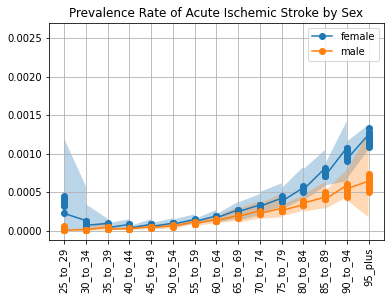

In [35]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [36]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

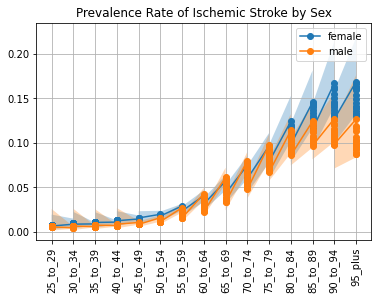

In [37]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [38]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000507,0.000040,0.002312
1,25_to_29,female,2024,0.000457,0.000048,0.002159
2,25_to_29,female,2025,0.000438,0.000055,0.002145
3,25_to_29,female,2026,0.000414,0.000032,0.002108
4,25_to_29,female,2027,0.000369,0.000035,0.001930


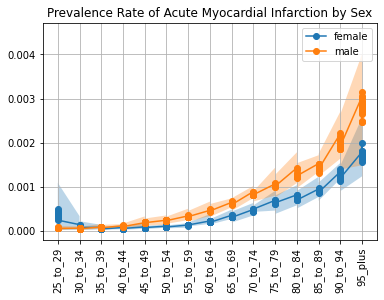

In [39]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [40]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.005827,0.001506,0.015322
1,25_to_29,female,2024,0.006194,0.001522,0.015966
2,25_to_29,female,2025,0.006523,0.001523,0.016519
3,25_to_29,female,2026,0.006694,0.001518,0.016870
4,25_to_29,female,2027,0.006784,0.001419,0.016798


In [43]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

In [47]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for age in prev_post_MI_summ.age.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

This seems to trend upwards. I am a bit concerned about it

### Angina

In [48]:
prev_angina = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
prev_angina = prev_angina.rename(columns = {'ptvalue':'value'})
prev_angina = pd.concat([prev_angina, per_time_group.ptvalue], axis=1)
prev_angina['rate']= prev_angina['value'] / prev_angina['ptvalue']
prev_angina_summ = (prev_angina
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_summ.head()

year,age,sex


In [49]:
#%%capture
for sex in prev_angina_summ.sex.unique():
    for year in prev_angina_summ.year.unique():
        plt.figure() 
        subdata =prev_angina_summ.loc[(prev_angina_summ.sex==sex) & (prev_angina_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Angina Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [50]:
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [51]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,2,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,45.4,1.000,254.925
1,8,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,42.9,1.000,251.575
2,14,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,38.7,2.225,222.225
3,20,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,36.1,1.450,210.950
4,26,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,37.6,0.225,225.875


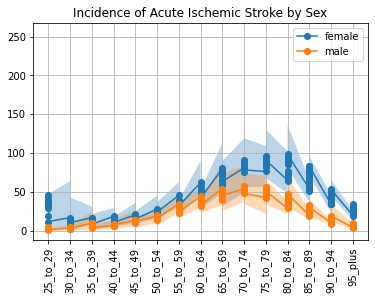

In [52]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [53]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,20,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,27136.657084
1,21,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,27428.347707
2,22,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,27448.969199
3,23,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,27293.043121
4,24,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,27152.449008


In [54]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001678,0.000036,0.009449
1,25_to_29,female,2024,0.001603,0.000037,0.009426
2,25_to_29,female,2025,0.001460,0.000083,0.008408
3,25_to_29,female,2026,0.001369,0.000055,0.008026
4,25_to_29,female,2027,0.001436,0.000008,0.008652


In [55]:
%%capture
with PdfPages('model9_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [56]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.006456  0.000469  0.029766
                2024  0.005997  0.000491  0.028757
                2025  0.005758  0.000598  0.027754
                2026  0.005404  0.000431  0.027846
                2027  0.004839  0.000459  0.025558

In [57]:
%%capture
with PdfPages('model9_acute_MI_inc.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Angina 

In [58]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(['angina_susceptible_to_angina'])].reset_index() 
tran_rate_angina = tran.loc[(tran['transition'].isin(['angina_susceptible_to_angina_to_angina']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

,year
age,sex


In [261]:
%%capture
with PdfPages('model3vv_angina_inc.pdf') as pdf:
    for sex in tran_angina_summ.index.get_level_values('sex').unique():
        for year in tran_angina_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex) & (tran_angina_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [59]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  washington.hdf


In [60]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [61]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [62]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [63]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [64]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [170]:
art_rr_bmi = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_rr_bmi['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_rr_bmi.age_start,art_rr_bmi.age_end)]
art_rr_bmi = art_rr_bmi.loc[art_rr_bmi.affected_entity == 'acute_myocardial_infarction']
art_rr_bmi

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.274461,1.258873,3.683201,Alabama,relative_risk,25_to_29
1,female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.017782,1.300431,3.098545,Alabama,relative_risk,30_to_34
2,female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.724084,1.533185,1.930238,Alabama,relative_risk,35_to_39
3,female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.598793,1.418497,1.784148,Alabama,relative_risk,40_to_44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,male,80.0,85.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.169882,1.091441,1.252069,Alabama,relative_risk,80_to_84
27,male,85.0,90.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.169882,1.091441,1.252069,Alabama,relative_risk,85_to_89
28,male,90.0,95.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.169882,1.091441,1.252069,Alabama,relative_risk,90_to_94
29,male,95.0,125.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.169882,1.091441,1.252069,Alabama,relative_risk,95_to_124


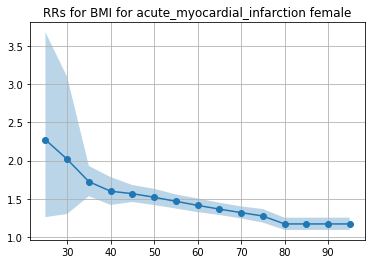

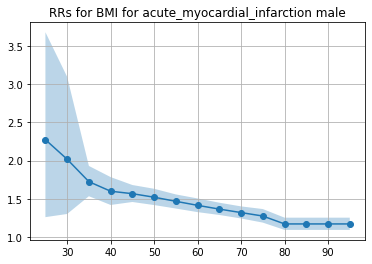

In [181]:
for sex in art_rr_bmi.sex.unique():
    for entity in art_rr_bmi.affected_entity.unique():
        plt.figure() 
        subdata = art_rr_bmi.loc[(art_rr_bmi.sex == sex) & (art_rr_bmi.affected_entity == entity)]
        plt.plot(subdata['age_start'],subdata['mean'],marker='o')
        plt.fill_between(subdata['age_start'],subdata['2.5%'],subdata['97.5%'],alpha=0.3)
        plt.title(f'RRs for BMI for {entity} {sex}')
        plt.grid()

In [182]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_3']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_3": "rr_gbd_bmi"}).reset_index()
rrs_bmi

,index,age_group_id,sex_id,rr_gbd_bmi,age_start,sex
0,47,19,1,1.299900,70,Male
1,48,20,1,1.244884,75,Male
2,49,18,1,1.396062,65,Male
3,50,16,1,1.502170,55,Male
...,...,...,...,...,...,...
192,6967,17,1,1.371216,60,Male
193,7292,30,1,1.130441,80,Male
194,7327,31,1,1.130441,85,Male
195,7362,32,1,1.130441,90,Male


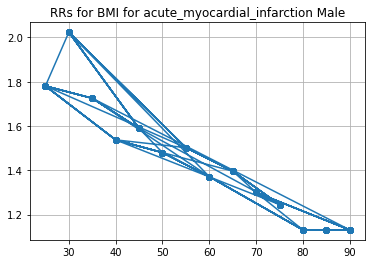

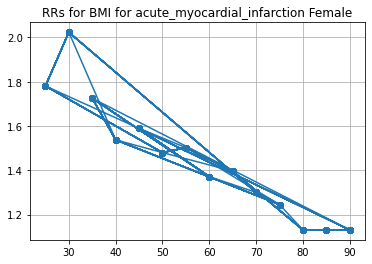

In [183]:
for sex in rrs_bmi.sex.unique():
    plt.figure() 
    subdata = rrs_bmi.loc[(rrs_bmi.sex == sex)]
    plt.plot(subdata['age_start'],subdata['rr_gbd_bmi'],marker='o')
    plt.title(f'RRs for BMI for {entity} {sex}')
    plt.grid()

#### All Cause Mortality Rates

In [65]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [66]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.002386,0.000912,0.009738
1,25_to_29,male,0.002545,0.001784,0.003354
2,30_to_34,female,0.001733,0.000984,0.002525
3,30_to_34,male,0.002642,0.001959,0.003400
4,35_to_39,female,0.001901,0.001297,0.002578


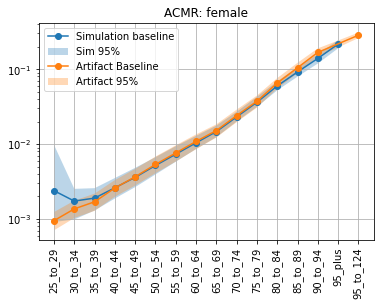

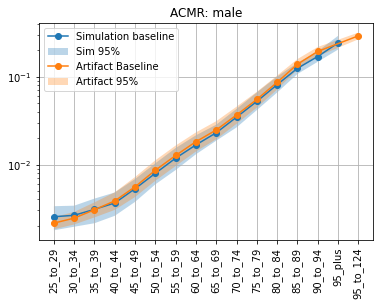

In [67]:
with PdfPages('model9_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [68]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [69]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [70]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [71]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [72]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000144,0.0,0.001209
1,25_to_29,male,0.000008,0.0,0.000077
2,30_to_34,female,0.000020,0.0,0.000149
3,30_to_34,male,0.000007,0.0,0.000039
4,35_to_39,female,0.000015,0.0,0.000077


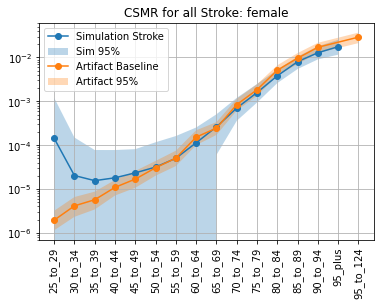

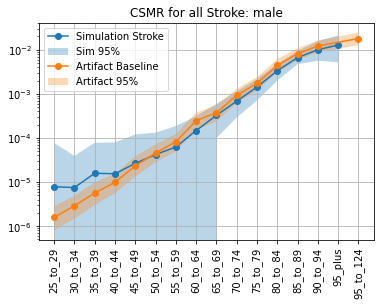

In [73]:
with PdfPages('model9_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Myocardial Infarction

In [74]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000017,0.000012,0.000024,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000047,0.000034,0.000064,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000098,0.000072,0.000132,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000232,0.000165,0.000311,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000393,0.000291,0.000513,Alabama,cause_specific_mortality_rate,45_to_49


In [75]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [76]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

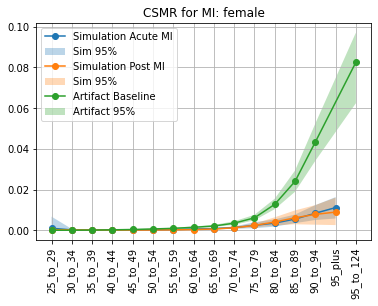

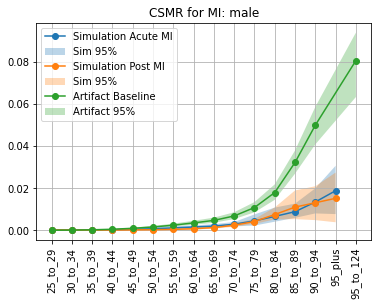

In [77]:
with PdfPages('model9_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_rate_allyear.loc[(acute_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = post_MI_rate_allyear.loc[(post_MI_rate_allyear.sex==sex)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Acute MI', 'Sim 95%', 'Simulation Post MI', 'Sim 95%','Artifact Baseline', 'Artifact 95%']) 

In [78]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001309,0.000127,0.007530
1,25_to_29,male,0.000406,0.000111,0.000767
2,30_to_34,female,0.000392,0.000076,0.000847
3,30_to_34,male,0.000271,0.000072,0.000526
4,35_to_39,female,0.000241,0.000038,0.000518


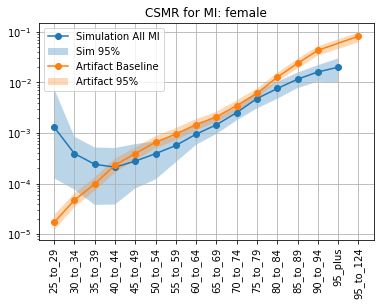

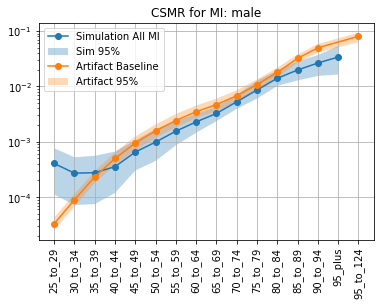

In [79]:
for sex in total_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = total_MI_rate_allyear.loc[(total_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [80]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [81]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001342,0.000000,0.010709
1,25_to_29,male,0.000094,0.000000,0.000296
2,30_to_34,female,0.000419,0.000036,0.002060
3,30_to_34,male,0.000117,0.000000,0.000342
4,35_to_39,female,0.000425,0.000055,0.001001


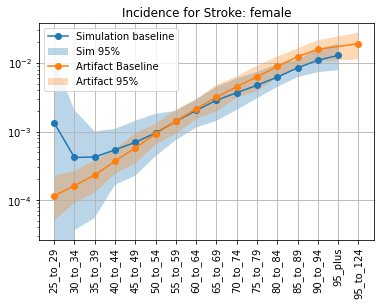

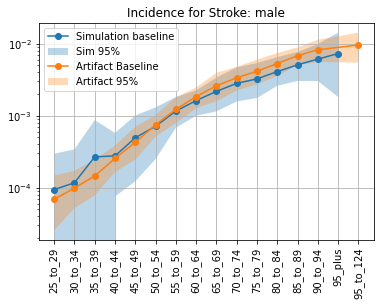

In [82]:
with PdfPages('model9_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [83]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [84]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.005068  0.000471  0.025800
         male    0.000882  0.000416  0.001609
30_to_34 female  0.001141  0.000386  0.002951
         male    0.000699  0.000373  0.001162
35_to_39 female  0.000694  0.000365  0.001238

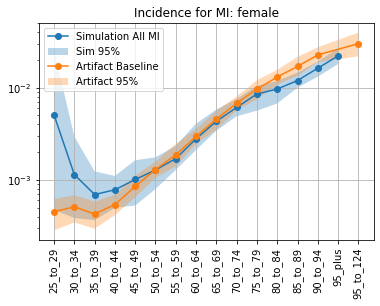

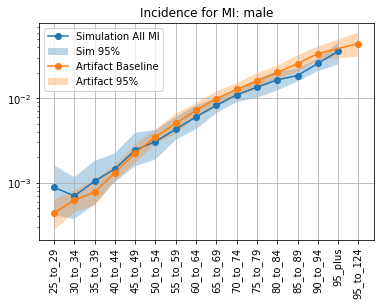

In [85]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina

In [86]:
art_inc_angina = load_artifact_data('cause', 'angina', 'incidence_rate')
art_inc_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_angina.age_start, art_inc_angina.age_end)]
art_inc_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000061,0.000042,0.000082,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000088,0.000060,0.000121,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000115,0.000075,0.000160,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000149,0.000109,0.000193,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000189,0.000108,0.000289,Alabama,incidence_rate,45_to_49


In [87]:
groupby_cols = ['age', 'sex']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

sex
age


In [88]:
for sex in tran_angina_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_angina.loc[(art_inc_angina.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

KeyError: 'Requested level (sex) does not match index name (age)'

#### Prevalence Rates

In [89]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [90]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


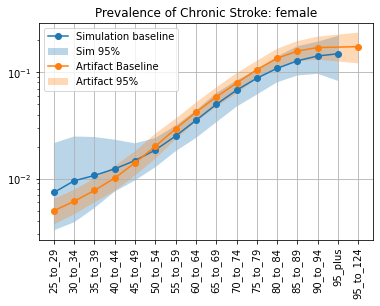

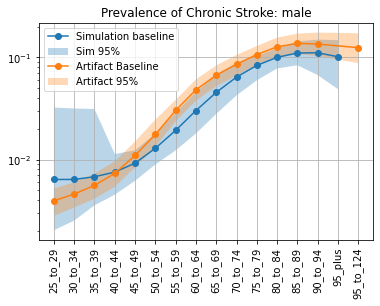

In [91]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [92]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [93]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

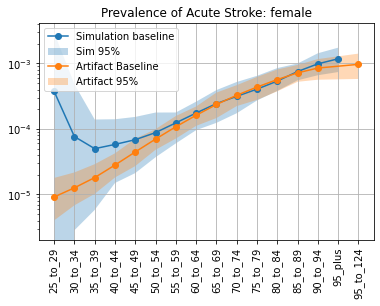

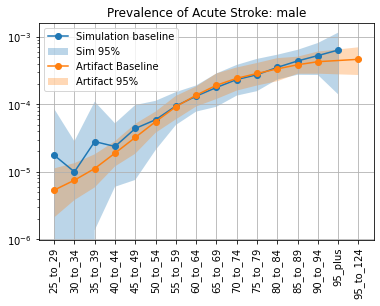

In [94]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [95]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [96]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.006671,0.001398,0.017029
1,25_to_29,male,0.003147,0.000956,0.008711
2,30_to_34,female,0.008512,0.002643,0.021813
3,30_to_34,male,0.004332,0.002075,0.007999
4,35_to_39,female,0.009022,0.003968,0.020963


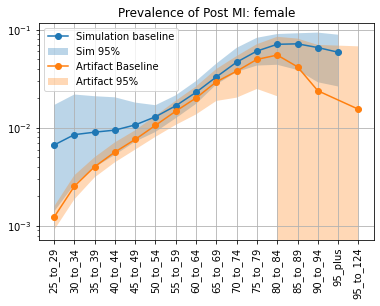

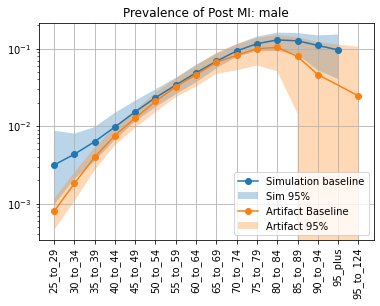

In [97]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Acute MI

In [98]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [99]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000384,0.000025,0.002532
1,25_to_29,male,0.000068,0.000019,0.000140
2,30_to_34,female,0.000089,0.000019,0.000265
3,30_to_34,male,0.000054,0.000018,0.000110
4,35_to_39,female,0.000054,0.000017,0.000115


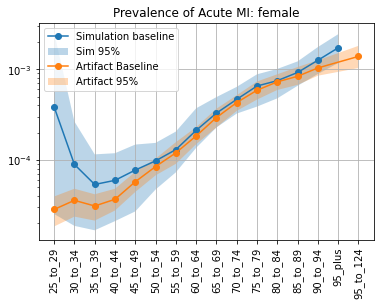

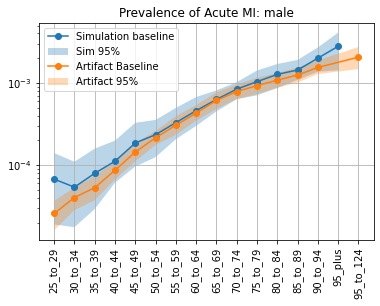

In [100]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina

In [310]:
art_prev_angina = load_artifact_data('cause', 'angina', 'prevalence')
art_prev_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_angina.age_start,art_prev_angina.age_end)]
art_prev_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000141,0.000093,0.000197,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000289,0.000198,0.000390,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000574,0.000381,0.000790,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.001131,0.000791,0.001517,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.001916,0.001455,0.002449,Alabama,prevalence,45_to_49


In [311]:
prev_angina_sum_allyear = (prev_angina
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000148,0.000122,0.000177
1,25_to_29,male,0.000204,0.000180,0.000256
2,30_to_34,female,0.000331,0.000283,0.000377
3,30_to_34,male,0.000425,0.000370,0.000499
4,35_to_39,female,0.000650,0.000580,0.000703


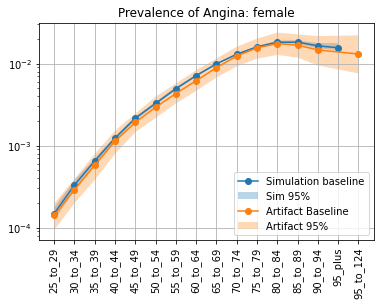

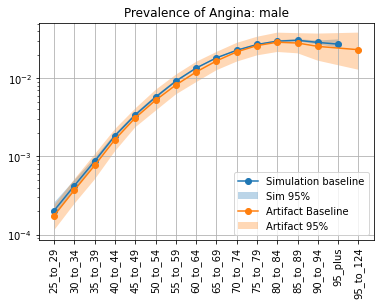

In [312]:
for sex in prev_angina_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_angina_sum_allyear.loc[(prev_angina_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_angina.loc[(art_prev_angina.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Excess Mortality Rate

#### Acute Stroke

In [101]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [102]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.409337,0.0,2.104225
1,25_to_29,male,0.383203,0.0,4.348214
2,30_to_34,female,0.242389,0.0,2.006868
3,30_to_34,male,0.889187,0.0,13.044643
4,35_to_39,female,0.312455,0.0,2.402388


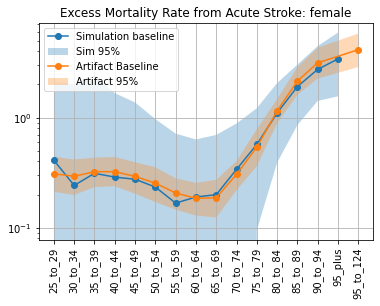

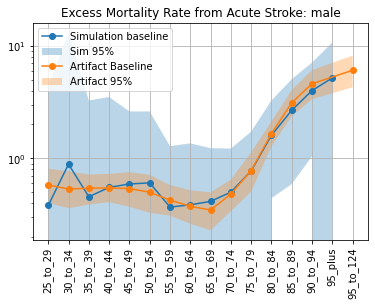

In [103]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [104]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [105]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000000,0.0,0.000000
1,25_to_29,male,0.000007,0.0,0.000000
2,30_to_34,female,0.000037,0.0,0.000000
3,30_to_34,male,0.000125,0.0,0.000000
4,35_to_39,female,0.000115,0.0,0.002036


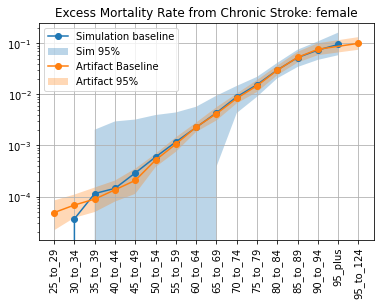

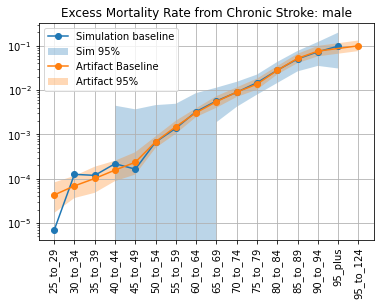

In [106]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [107]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [108]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.669347,0.887006,4.901333
1,25_to_29,male,3.693708,1.304464,6.522321
2,30_to_34,female,2.238719,0.000000,5.022188
3,30_to_34,male,2.753370,0.000000,5.577944
4,35_to_39,female,1.710134,0.000000,4.348214


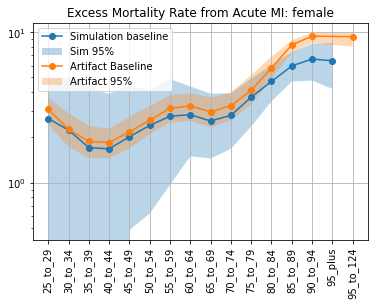

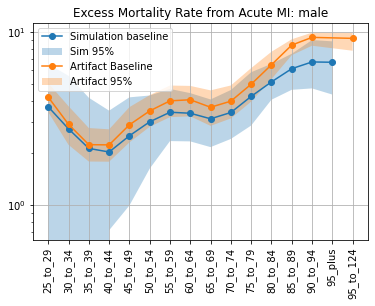

In [109]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [110]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.045837,0.009907,0.087218
1,25_to_29,male,0.055165,0.000000,0.125999
2,30_to_34,female,0.024626,0.000000,0.054014
3,30_to_34,male,0.027174,0.000000,0.059388
4,35_to_39,female,0.015697,0.000000,0.035388


In [111]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

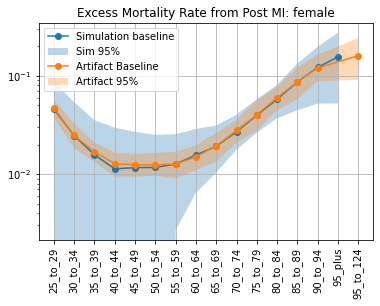

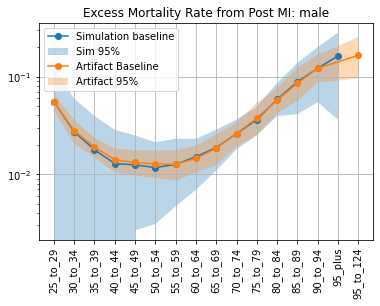

In [112]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina EMR

In [327]:
art_emr_angina = load_artifact_data('cause', 'angina', 'excess_mortality_rate')
art_emr_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_angina.age_start,art_emr_angina.age_end)]
art_emr_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.282008,0.206508,0.368893,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.173751,0.129001,0.225407,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.065495,0.050426,0.083836,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.009768,0.005119,0.016087,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.006571,0.003868,0.010055,Alabama,excess_mortality_rate,45_to_49


In [336]:
angina_emr = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
angina_death_cause = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_emr_rate = pd.concat([angina_death_cause, angina_emr.ptvalue], axis=1)
angina_emr_rate['mean_rate'] = angina_emr_rate['value'] / angina_emr_rate['ptvalue']
angina_emr_rate_allyear = (angina_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


angina_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.279425,0.123912,0.392377
1,25_to_29,male,0.314665,0.177206,0.453807
2,30_to_34,female,0.161115,0.090310,0.231990
3,30_to_34,male,0.222622,0.172365,0.308390
4,35_to_39,female,0.062634,0.019957,0.100492


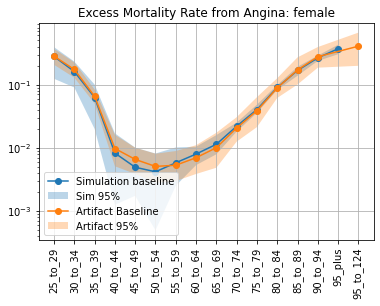

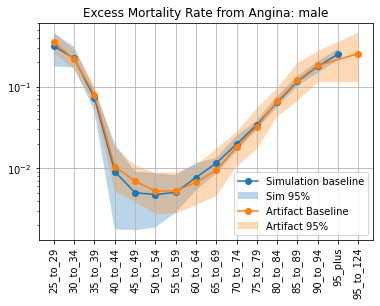

In [337]:
for sex in angina_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = angina_emr_rate_allyear.loc[(angina_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_angina.loc[(art_emr_angina.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

# GBD Comparison

#### All Cause Mortality Rate

In [113]:
from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws


In [114]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [115]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,1,3,1,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002153,0.002516,0.001834,25_to_29
1,10,294,523,1,3,2,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.000950,0.001237,0.000706,25_to_29
2,11,294,523,1,3,1,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002456,0.002887,0.002079,30_to_34
3,11,294,523,1,3,2,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001364,0.001755,0.001029,30_to_34
4,12,294,523,1,3,1,2019,_all,35 to 39,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.003056,0.003710,0.002501,35_to_39


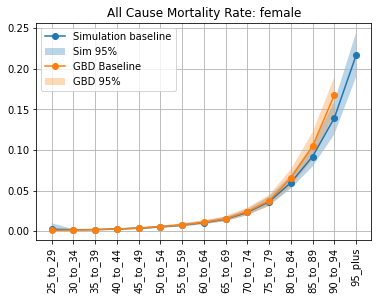

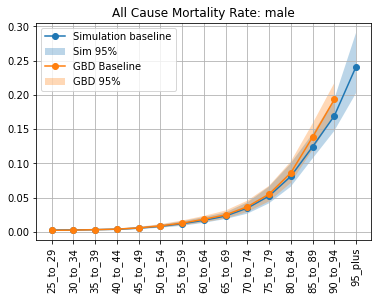

In [116]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### CSMR for IHD

In [117]:
gbd_csmr_ihd = go("cause", gbd_round_id=6, 
              age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], 
              cause_id=493, 
              measure_id=1, 
              metric_id=3, 
              location_id=523, 
              year_id=2019, 
              sex_id=[1,2], 
              decomp_step='step5')
gbd_csmr_ihd['age'] = gbd_csmr_ihd.age_group_name.str.replace(' ', '_')
#gbd_csmr_ihd.head()

In [118]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate.head()

,index,age,sex,year,input_draw,cause,value,ptvalue,mean_rate
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27441.379877,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27571.394935,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27621.530459,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27463.151266,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27323.937029,NaN


In [176]:
#total_MI_rate.head()

In [119]:
total_MI_rate = total_MI_rate.rename(columns = {'total_rate':'mi_total_rate'})
angina_rate = angina_rate.rename(columns = {'mean_rate':'angina_rate'})
ihd_rate = pd.concat([total_MI_rate, angina_rate.angina_rate], axis=1)
ihd_rate['total_rate'] = ihd_rate['mi_total_rate'] + ihd_rate['angina_rate']
ihd_rate.head()

,index,age,sex,year,input_draw,cause,value,ptvalue,acute_rate,post_rate,mi_total_rate,angina_rate,total_rate
0,1,25_to_29,female,2023,29,acute_myocardial_infarction,7,27441.379877,0.000255,0.000073,0.000328,NaN,NaN
1,6,25_to_29,female,2023,232,acute_myocardial_infarction,1,27571.394935,0.000036,0.000254,0.000290,NaN,NaN
2,11,25_to_29,female,2023,357,acute_myocardial_infarction,7,27621.530459,0.000253,0.000109,0.000362,NaN,NaN
3,16,25_to_29,female,2023,394,acute_myocardial_infarction,0,27463.151266,0.000000,0.000109,0.000109,NaN,NaN
4,21,25_to_29,female,2023,602,acute_myocardial_infarction,19,27323.937029,0.000695,0.000146,0.000842,NaN,NaN


In [120]:
ihd_rate_allyear = (ihd_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
#ihd_rate_allyear.head()

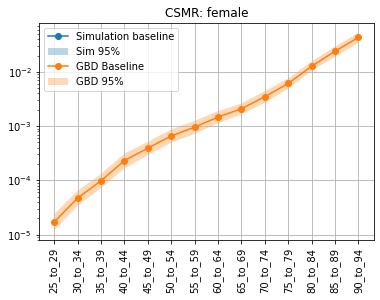

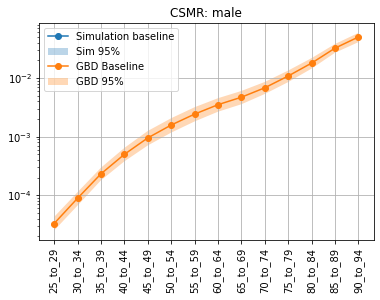

In [121]:
for sex in ihd_rate_allyear.sex.unique():
    plt.figure() 
    subdata = ihd_rate_allyear.loc[(ihd_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_csmr_ihd.loc[(gbd_csmr_ihd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'CSMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [122]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [123]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,6,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000068,0.000147,0.000025,25_to_29
1,10,495,523,6,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000115,0.000224,0.000050,25_to_29
2,11,495,523,6,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000098,0.000171,0.000052,30_to_34
3,11,495,523,6,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000162,0.000265,0.000091,30_to_34
4,12,495,523,6,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000145,0.000243,0.000077,35_to_39


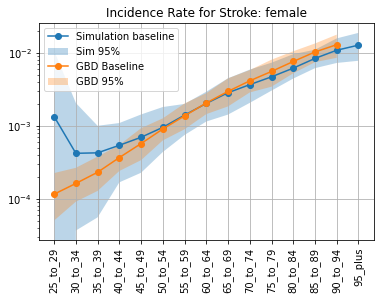

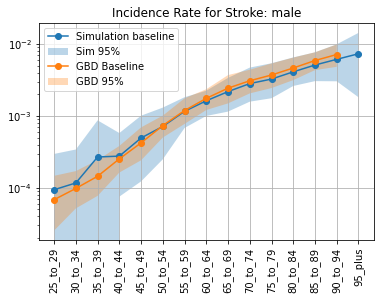

In [124]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [125]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,6,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000441,0.000626,0.000274,25_to_29
1,10,493,523,6,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000452,0.000616,0.000284,25_to_29
2,11,493,523,6,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000621,0.000818,0.000448,30_to_34
3,11,493,523,6,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000510,0.000683,0.000345,30_to_34
4,12,493,523,6,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000777,0.001081,0.000536,35_to_39


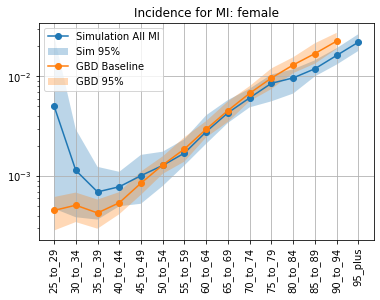

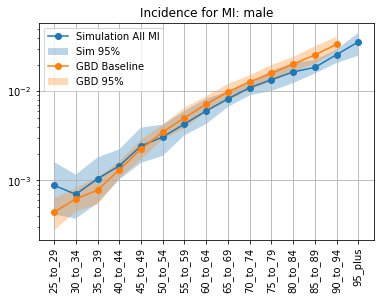

In [126]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [127]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.004995,0.000259,0.033279
1,25_to_29,male,0.000877,0.000216,0.001806
2,30_to_34,female,0.001135,0.000232,0.003514
3,30_to_34,male,0.000698,0.000221,0.001434
4,35_to_39,female,0.000693,0.000207,0.001550


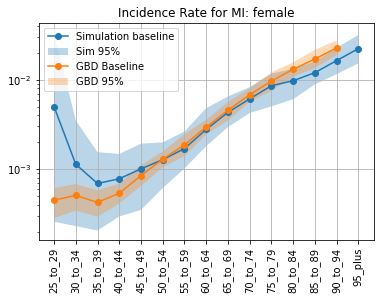

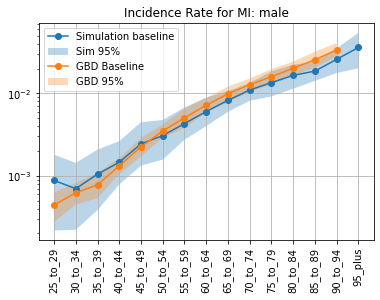

In [128]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Incidence for Angina

In [390]:
angina_inc = get_draws('modelable_entity_id',
                1817,
                source='epi',
                location_id=523,
                age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
                sex_id=[1,2],
                measure_id = 6,
                year_id=2019,
                gbd_round_id=6,
                 decomp_step='step4')
angina_inc['age_group'] = np.where(angina_inc['age_group_id']==10,'25_to_29',np.where(angina_inc['age_group_id']==11,'30_to_34',np.where(angina_inc['age_group_id']==12,'35_to_39',np.where(angina_inc['age_group_id']==13,'40_to_44',np.where(angina_inc['age_group_id']==14,'45_to_49',np.where(angina_inc['age_group_id']==15,'50_to_54',np.where(angina_inc['age_group_id']==16,'55_to_59',np.where(angina_inc['age_group_id']==17,'60_to_64',np.where(angina_inc['age_group_id']==18,'65_to_69',np.where(angina_inc['age_group_id']==19,'70_to_74',np.where(angina_inc['age_group_id']==20,'75_to_79',np.where(angina_inc['age_group_id']==30,'80_to_84',np.where(angina_inc['age_group_id']==31,'85_to_89',np.where(angina_inc['age_group_id']==32,'90_to_94',np.where(angina_inc['age_group_id']==33,'95_to_100',0)))))))))))))))
angina_inc['sex'] = np.where(angina_inc['sex_id']==1,'Male','Female')
mean_df = angina_inc.iloc[:,1:1001]
angina_inc['mean'] = mean_df.mean(axis=1)
angina_inc = angina_inc.sort_values(by=['age_group'])
#angina_inc

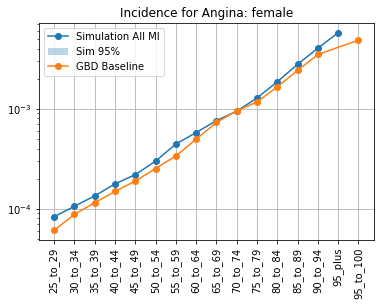

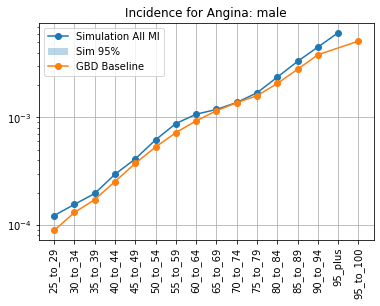

In [394]:
for sex in tran_angina_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = angina_inc.loc[(angina_inc.sex==sex.capitalize())]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.title(f'Incidence for Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline']) 

#### DALYs from Stroke

In [129]:
gbd_daly = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [130]:
gbd_daly['age'] = gbd_daly.age_group_name.str.replace(' ', '_')
gbd_daly.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,2,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000573,0.000875,0.000337,25_to_29
1,10,495,523,2,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.000837,0.001272,0.000515,25_to_29
2,11,495,523,2,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000723,0.001057,0.000457,30_to_34
3,11,495,523,2,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001110,0.001578,0.000720,30_to_34
4,12,495,523,2,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000972,0.001417,0.000638,35_to_39


In [131]:
yll_stroke = yll.loc[yll['cause'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld.loc[yld['cause_of_disability'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld_stroke.rename(columns = {'cause_of_disability':'cause'})
yld_stroke

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,cause,yld
0,0,0,female,2023,ylds,29,baseline,25_to_29,acute_ischemic_stroke,0.013058
1,1,1,female,2023,ylds,29,baseline,30_to_34,acute_ischemic_stroke,0.001228
2,2,2,female,2023,ylds,29,baseline,35_to_39,acute_ischemic_stroke,0.000774
3,3,3,female,2023,ylds,29,baseline,40_to_44,acute_ischemic_stroke,0.002754
...,...,...,...,...,...,...,...,...,...,...
10796,16196,16196,male,2040,ylds,946,baseline,80_to_84,chronic_ischemic_stroke,204.939360
10797,16197,16197,male,2040,ylds,946,baseline,85_to_89,chronic_ischemic_stroke,137.570737
10798,16198,16198,male,2040,ylds,946,baseline,90_to_94,chronic_ischemic_stroke,53.123210
10799,16199,16199,male,2040,ylds,946,baseline,95_plus,chronic_ischemic_stroke,18.382565


In [132]:
daly_stroke = yll_stroke.merge(yld_stroke[['yld','sex','age','year','cause']], on=['sex','age','year','cause'])
daly_stroke['daly'] = daly_stroke['yll'] + daly_stroke['yld']
daly_stroke.head()

,index,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,yll,yld,daly
0,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,120.096394,0.013058,120.109452
1,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,120.096394,0.000000,120.096394
2,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,120.096394,0.001666,120.098060
3,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,120.096394,0.000342,120.096736
4,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,120.096394,0.000205,120.096599


In [133]:
daly_stroke = daly_stroke.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_stroke_rate = pd.concat([daly_stroke, per_time_group.ptvalue], axis=1)
daly_stroke_rate['daly_rate'] = daly_stroke_rate['daly'] / daly_stroke_rate['ptvalue']
daly_stroke_sum_allyear = (daly_stroke_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_stroke_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.102557,0.011722,0.770575
1,25_to_29,male,0.014089,0.008291,0.058818
2,30_to_34,female,0.028021,0.015094,0.101775
3,30_to_34,male,0.013488,0.006653,0.032983
4,35_to_39,female,0.025976,0.015006,0.059082


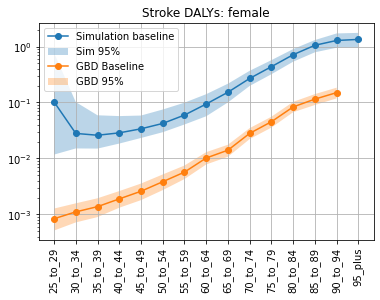

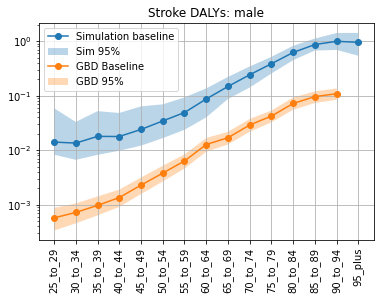

In [134]:
for sex in daly_stroke_sum_allyear.sex.unique():
    plt.figure() 
    subdata = daly_stroke_sum_allyear.loc[(daly_stroke_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly.loc[(gbd_daly.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Stroke DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [135]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [136]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,2,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.002084,0.002684,0.001595,25_to_29
1,10,493,523,2,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001076,0.001488,0.000753,25_to_29
2,11,493,523,2,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.005151,0.006505,0.003896,30_to_34
3,11,493,523,2,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.002720,0.003687,0.001977,30_to_34
4,12,493,523,2,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.012157,0.015460,0.009483,35_to_39


In [137]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [138]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

,age,sex,year,input_draw,yll,yld,daly
0,25_to_29,female,2023,29,554.262615,0.209835,554.472450
1,25_to_29,female,2023,232,504.209618,0.367212,504.576830
2,25_to_29,female,2023,357,616.618921,0.218579,616.837499
3,25_to_29,female,2023,394,181.333317,0.174863,181.508180
4,25_to_29,female,2023,602,1423.496506,0.393441,1423.889947


In [139]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.081383,0.007852,0.471244
1,25_to_29,male,0.025019,0.006842,0.046854
2,30_to_34,female,0.022275,0.004318,0.048088
3,30_to_34,male,0.015396,0.004026,0.029893
4,35_to_39,female,0.012491,0.002045,0.026988


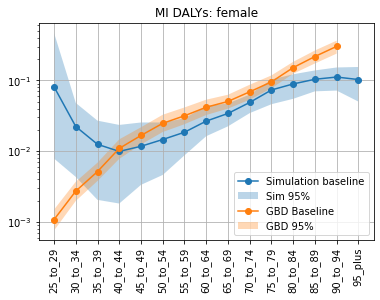

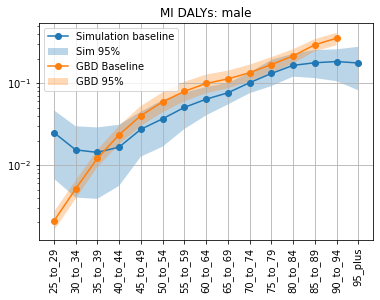

In [140]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### LDL-C Testing - Total Exposure by age/year

In [141]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
ldl = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
150,150,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,25_to_29,73900.036033
151,151,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,30_to_34,72306.307870
152,152,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,35_to_39,70148.926016
153,153,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,40_to_44,68845.674305
154,154,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,45_to_49,65298.480839


In [142]:
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#ldl_summ

In [143]:
%%capture
for sex in ldl_summ.sex.unique():
    for year in ldl_summ.year.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.ylim(0,100000)
        plt.grid()

In [144]:
%%capture
for sex in ldl_summ.sex.unique():
    for age in ldl_summ.age.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

The absolute number is definitely changing over time. Let's see if this is due to changes in population structure or something else. 

### Rates of Exposure by Age/Year

In [145]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.742686,2.516588,2.995409
1,25_to_29,female,2024,2.752020,2.525434,3.005266
2,25_to_29,female,2025,2.761604,2.537081,3.014568
3,25_to_29,female,2026,2.768131,2.542867,3.019631
4,25_to_29,female,2027,2.770279,2.545265,3.020748


In [147]:
## Want to think through these. These are now rates - why is it dropping at older age groups? Selection bias 
## (those with high cholestrol don't live as long?) Something else? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for year in ldl_rate_summ.year.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [149]:
## These look a bit funny - we should discuss. What is causing changes over time across these groups? 
## Why is this not 3? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for age in ldl_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


### Within 2023, LDL-C Distribution 

In [150]:
ldl_2023 = ldl.loc[ldl['year']==2023].reset_index()
ldl_2023.head()

,index,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,150,150,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,25_to_29,73900.036033
1,151,151,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,30_to_34,72306.307870
2,152,152,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,35_to_39,70148.926016
3,153,153,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,40_to_44,68845.674305
4,154,154,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,45_to_49,65298.480839


### Compare with Artifact 
'risk_factor.high_ldl_cholesterol.distribution' - just says "ensemble"

'risk_factor.high_ldl_cholesterol.exposure'

'risk_factor.high_ldl_cholesterol.exposure_standard_deviation'

'risk_factor.high_ldl_cholesterol.exposure_distribution_weights'- weights of the ensemble dist

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

'risk_factor.high_ldl_cholesterol.tmred' - GBD values, no testing

'risk_factor.high_ldl_cholesterol.relative_risk_scalar' - this is just 1

In [151]:
ldl_exp = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp.age_start,ldl_exp.age_end)]
ldl_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.805110,2.597516,3.051877,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.790157,2.588387,2.991761,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.855153,2.640309,3.069596,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.864634,2.652549,3.073091,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.994765,2.785903,3.219201,Alabama,exposure,45_to_49


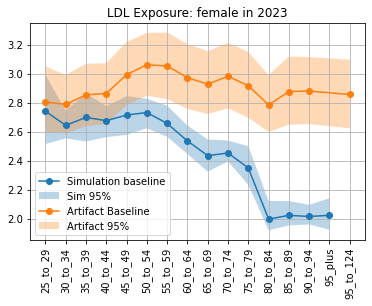

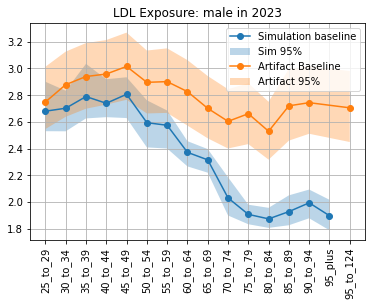

In [152]:
for sex in ldl_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_exp.loc[(ldl_exp.sex==sex) & (ldl_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### High SBP Risk Factor Testing 

In [153]:
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
300,300,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,25_to_29,3.206571e+06
301,301,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,30_to_34,3.367634e+06
302,302,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,35_to_39,2.867834e+06
303,303,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,40_to_44,3.133676e+06
304,304,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,45_to_49,2.923309e+06


In [154]:
sbp_summ = (sbp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#sbp_summ

In [155]:
%%capture
for sex in sbp_summ.sex.unique():
    for year in sbp_summ.year.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [156]:
#Some interesting patterns going on here - since it is not a rate I am not overly concerned but might be worth a look
%%capture
for sex in sbp_summ.sex.unique():
    for age in sbp_summ.age.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [158]:
sbp_rate = sbp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_rate = pd.concat([sbp_rate, per_time_group.ptvalue], axis=1)
sbp_rate['ldl_rate'] = sbp_rate['value'] / sbp_rate['ptvalue']
sbp_rate_summ = (sbp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,114.483028,106.639143,120.135569
1,25_to_29,female,2024,114.410584,106.614873,120.054045
2,25_to_29,female,2025,114.349751,106.563851,119.966348
3,25_to_29,female,2026,114.324186,106.586204,119.921266
4,25_to_29,female,2027,114.333385,106.607839,119.937390


In [160]:
%%capture
for sex in sbp_rate_summ.sex.unique():
    for year in sbp_rate_summ.year.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [162]:
%%capture
for sex in sbp_rate_summ.sex.unique():
    for age in sbp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [163]:
sbp_exp = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp.age_start,sbp_exp.age_end)]
sbp_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,114.500732,101.716393,127.389503,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,113.207856,100.753767,126.385370,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,115.716469,103.617384,128.913762,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,118.712085,105.661678,133.771730,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,123.960399,110.054265,139.549595,Alabama,exposure,45_to_49


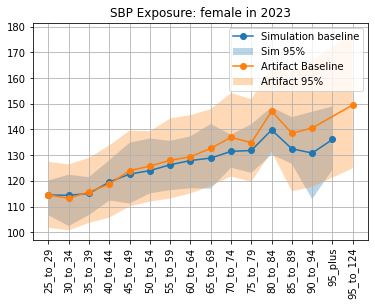

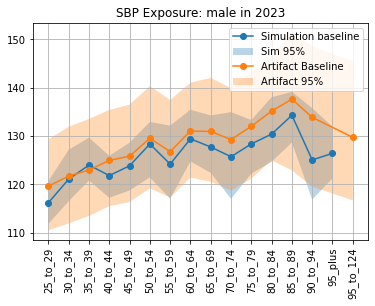

In [164]:
for sex in sbp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_exp.loc[(sbp_exp.sex==sex) & (sbp_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### High BMI Risk Factor Testing 

In [192]:
bmi = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,786436.236358
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,802276.012522
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,777699.351464
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,812180.124672
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,751098.853552


In [193]:
bmi_rate = bmi.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_rate = pd.concat([bmi_rate, per_time_group.ptvalue], axis=1)
bmi_rate['bmi_rate'] = bmi_rate['value'] / bmi_rate['ptvalue']
bmi_rate_summ = (bmi_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,28.241542,26.152876,31.496877
1,25_to_29,female,2024,28.195626,26.056098,31.505729
2,25_to_29,female,2025,28.140789,25.930613,31.511677
3,25_to_29,female,2026,28.088577,25.817972,31.482483
4,25_to_29,female,2027,28.062461,25.708126,31.497545


In [195]:
%%capture
for sex in bmi_rate_summ.sex.unique():
    for year in bmi_rate_summ.year.unique():
        plt.figure() 
        subdata = bmi_rate_summ.loc[(bmi_rate_summ.sex==sex) & (bmi_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [197]:
%%capture
for sex in bmi_rate_summ.sex.unique():
    for age in bmi_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_rate_summ.loc[(bmi_rate_summ.sex==sex) & (bmi_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

For young females (the problem group in this sim) the exposure looks higher in 2023 and then decreases. Unclear why this is, but worth investigating further

In [198]:
bmi_exp = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_exp.age_start,bmi_exp.age_end)]
bmi_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,28.518528,26.524912,30.673359,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,29.289824,27.211374,31.705342,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,29.284694,27.345055,31.659805,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,29.784466,27.629332,32.319997,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,29.780408,27.670340,32.443968,Alabama,exposure,45_to_49


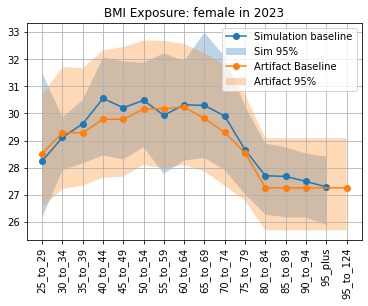

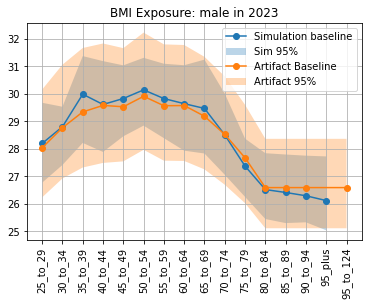

In [199]:
for sex in bmi_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_rate_summ.loc[(bmi_rate_summ.sex==sex) & (bmi_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_exp.loc[(bmi_exp.sex==sex) & (bmi_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 